In [151]:
COLORS = {
    'reset': '\033[0m',

    'red': '\033[31m',
    'green': '\033[32m',
    'yellow': '\033[33m',
    'blue': '\033[34m',
    'magenta': '\033[35m',
    'cyan': '\033[36m',
    'white': '\033[37m',
}

def GetColor(color_name: str) -> str:
    return COLORS.get(color_name, COLORS['reset'])

def Colored(text: str, color_name: str = 'green') -> str:
    return f"{GetColor(color_name)}{text}{GetColor('reset')}"


In [1]:
import numpy as np
from typing import Union


def Round(number: float, precision: int = 4) -> float:
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# =============================================================================

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return MakeVectors(people_industry, people_academia)

# =============================================================================

def CalculatePeopleDistribution(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# =============================================================================

def UnpackData(history: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_axis = history[:, 0]
    Y_axis_industry = history[:, 1]
    Y_axis_academia = history[:, 2]
    return X_axis, Y_axis_industry, Y_axis_academia

# =============================================================================

def FindChangeYears(people_history: list[tuple[int, np.ndarray]]) -> list[int]:
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    change_years = X_axis[change_indices + 1]
    return change_years.tolist()

# =============================================================================

def GetDataAs(
    percentage_industry: float, total_people: int, year: int,
    people_industry: float, people_academia: float,
    as_float: bool = True, precision: int = 4,
) -> Union[list[float], np.ndarray]:
    if as_float:
        return [
            Round(percentage_industry, precision), Round(total_people, precision), year,
            Round(people_industry, precision), Round(people_academia, precision),
        ]
    else:
        return np.array([
            percentage_industry, total_people, year, 
            people_industry, people_academia,
        ], dtype=float)

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1, response_as_float: bool = True, response_precision: int = 4,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    # Vector Structure: [percentage_industry, total_people, year, people_industry, people_academia]
    history.append(GetDataAs(percentage_industry, total_people, start, people[0], people[1], as_float=response_as_float, precision=response_precision))
    
    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append(GetDataAs(percentage_industry, total_people, year, people[0], people[1], as_float=response_as_float, precision=response_precision))

    return np.array(history, dtype=object)

def Simulation(
    total_people: int,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,
    percentage_people_industry: float,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> list[np.ndarray]:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i, # Pass total_people here
                percentage_industry=percentage_people_industry_j, # Pass percentage here
            )

            all_results.append(peopleHistory)

    return all_results



In [2]:
def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up

def GetGraphicParameters(
    people_history: list[tuple[int, np.ndarray]],
    initial_year: int, period_of_time: int,
) -> dict[str, object]:
    
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)
    
    return X_axis, Y_axis_industry, Y_axis_academia, {
        'Y_min': Y_min, 'Y_max': Y_max,
        'X_ticks': GetTicks(initial_value = initial_year, final_value = initial_year + period_of_time), 
        'Y_ticks': GetTicks(initial_value=Y_min, final_value=Y_max, dtype=float), 
    }

def GetMax(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return max(Array)

def GetMin(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return min(Array)

def GetMaxFromDict(data: dict[int, np.ndarray]) -> float:
    all_max = [GetMax(v) for v in data.values()]
    return max(all_max)

def GetMinFromDict(data: dict[int, np.ndarray]) -> float:
    all_min = [GetMin(v) for v in data.values()]
    return min(all_min)

def GetGlobalMaxAndMin(Responses: list[np.ndarray]) -> tuple[float, float]:
    AllMaximus, AllMinimus = [], []

    for response in Responses:
        u, v = response[:, -2], response[:, -1]
        AllMaximus.append(max(GetMax(u), GetMax(v)))
        AllMinimus.append(min(GetMin(u), GetMin(v)))

    return max(AllMaximus), min(AllMinimus), AllMaximus, AllMinimus



In [8]:
import matplotlib.pyplot as plt


def PlotByFixedPercentage(
        responses: list[np.ndarray], 
        percentage_index: int,
        Maximus: float,
    ) -> None:
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1])
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

    # Set Y-axis from 0 to Maximus with padding
    Y_max_padded = Maximus * 1.05  # Add 5% padding at the top
    Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, dtype=float)
    
    # Set X-axis ticks
    X_ticks = GetTicks(initial_value=years[0], final_value=years[-1])
    
    plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
    plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)
    
    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage of Researches in Industry Fixed at {target_percentage:.0%})')
    plt.xlabel('Years'); plt.ylabel('Number of People')
    plt.legend(); plt.grid(alpha=0.3); plt.show()


## `Question 02`:

`(a)` Imagine that in 2025, 30% of the ML researchers work in industry, while 70% work in academia. How will this distribution be changing over the next 100 years (assuming that the transition matrix stays the same)?

Make a plot to visualize industry vs. academia researchers distribution for each year from 2025 up to 2125 according to our model. Explain what you see.


`(b)` In some alternative universe, in 2025, the statistics look different: 90% of the researchers work in academia and only 10% are in industry. What will the distribution between industry and academia research be by 2125 in that case? How does it compare to the previous result?


In [3]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)


In [4]:
totalPeople = 10_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 100
finalYear = initialYear + periodOfTime

qntSampleTotalPeople = 8
stepSampleTotalPeople = 10_000

qntSamplePercentagePeopleIndustry = 2
stepSamplePercentagePeopleIndustry = 0.8



In [5]:
Responses = Simulation(
    
    # Given parameters:
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,

    # Sampling parameters:
    
    # 1. Vary total people:
    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    
    # 2. Vary initial percentage of people in industry:
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)

GlobalMaximus, GlobalMinimus, AllMaximus, AllMinimus = GetGlobalMaxAndMin(Responses)


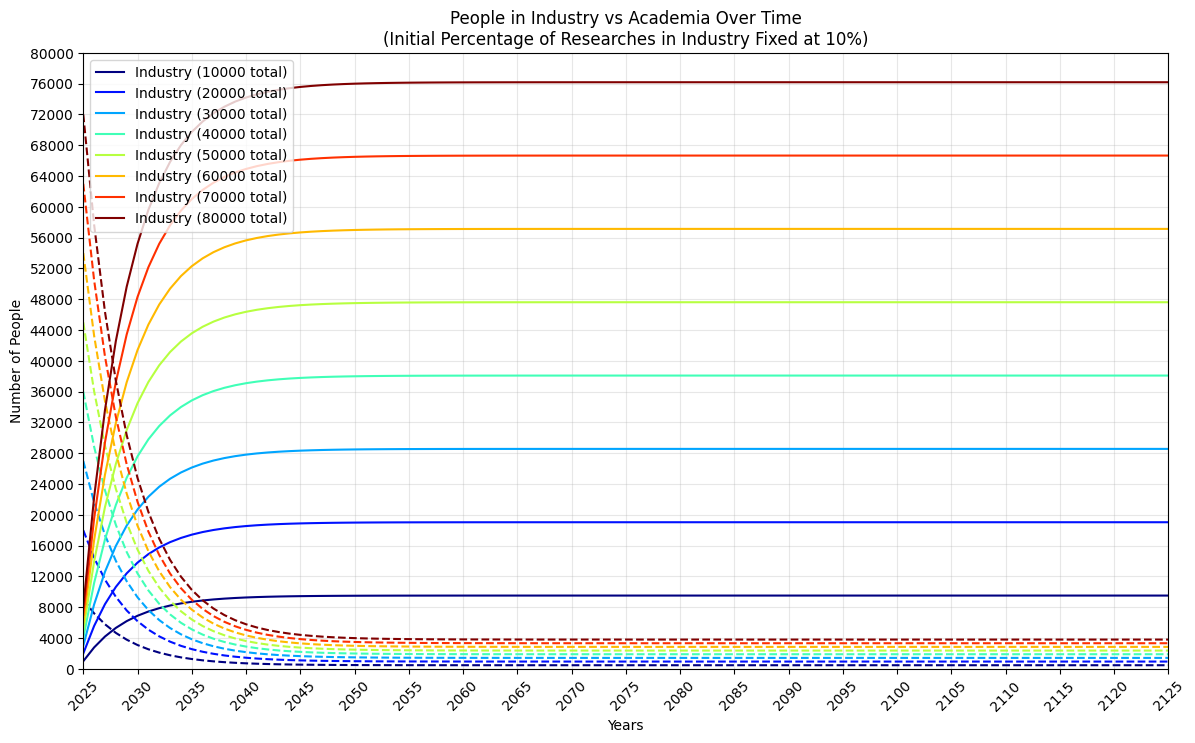

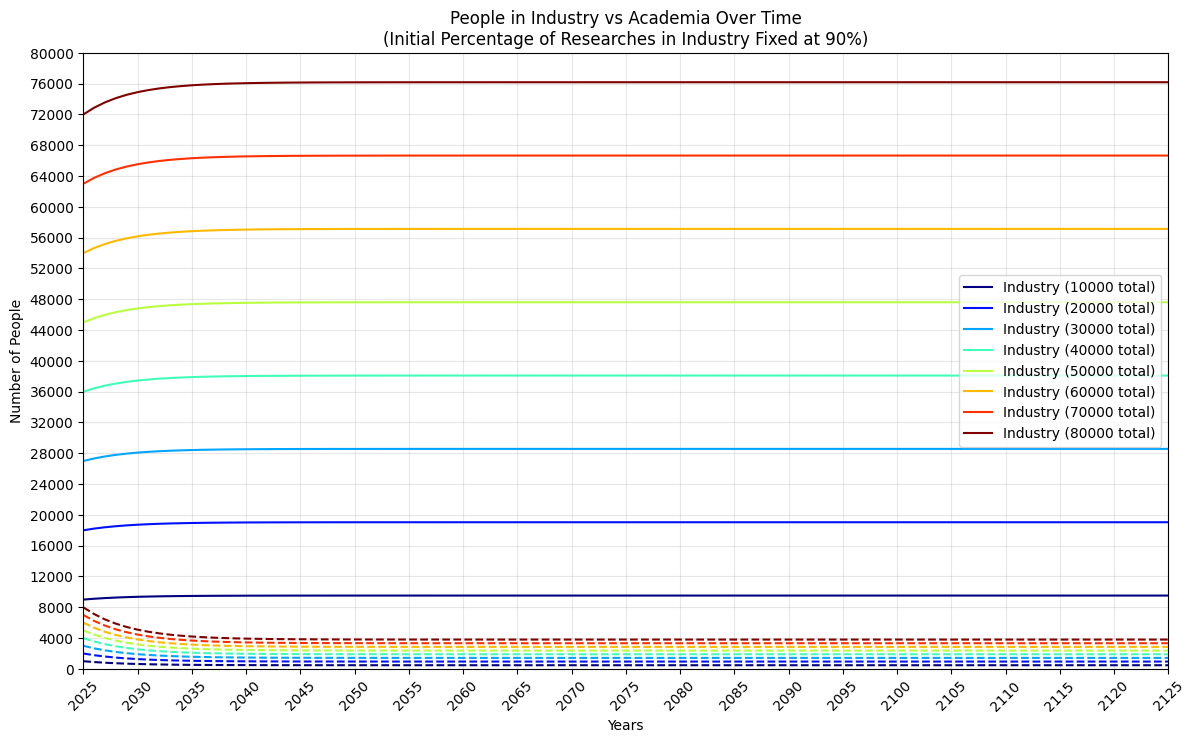

In [7]:
for simulation_people_by_percentage in range(qntSamplePercentagePeopleIndustry):
    PlotByFixedPercentage(
        responses=Responses, 
        Maximus=GlobalMaximus,
        percentage_index=simulation_people_by_percentage, 
    )


- As we can observe from the plots, in the first scenario, after the same period of time, the people in industry outnumber those in academia. 

- Furthermore, we can observe that the number of people in academia, independently of  the initial conditions, tends to stabilize around a certain value, meanwhile, the number of people in industry reaches differents maximus depending on the initial conditions.

- Important to notice is that the transition matrix is the same in both cases, which means that the probabilities of moving from one state to another are constant over time.

- In conclusion, in both scenarios, the number of researchers in academia tends to stabilize around a certain value, while the number of researchers in industry increases over time, eventually surpassing those in academia, but reaching a maximum.



## `Extra`:

* To check on that, would be interesting to see what is the ratio of people in industry vs academia developing over time. 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def CalculateRatioPerTotalPeople(
        responses: list[np.ndarray], 
        percentage_index: int,
    ) -> tuple[dict[int, np.ndarray], float]:

    data_flat = np.concatenate(responses, axis=0)

    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]

    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))

    ratios_per_total_people = {}
    for total_people in total_people_counts:

        current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]
        
        years = current_data[:, 2].astype(float)
        industry = current_data[:, 3].astype(float)
        academia = current_data[:, 4].astype(float)

        ratio = academia / industry
        ratio = np.nan_to_num(ratio, nan=0, posinf=0)

        ratios_per_total_people[int(total_people)] = ratio

    return ratios_per_total_people, float(target_percentage)


def GetAllRatios(responses: list[np.ndarray]) -> dict[float, dict[int, np.ndarray]]:
    all_ratios = {}
    data_flat = np.concatenate(responses, axis=0)
    all_percentages_values = np.unique(data_flat[:, 0].astype(float)).tolist()

    for i, _ in enumerate(all_percentages_values):
        ratios_per_total_people, target_percentage = CalculateRatioPerTotalPeople(responses=responses, percentage_index=i)
        all_ratios[target_percentage] = ratios_per_total_people

    return all_ratios


def AverageRatiosByPercentage(
    responses: list[np.ndarray],
    weighted: bool = False,
) -> dict[float, np.ndarray]:

    avg_ratios: dict[float, np.ndarray] = {}

    data_flat = np.concatenate(responses, axis=0)
    all_percentages = np.unique(data_flat[:, 0].astype(float)).tolist()

    for i, _ in enumerate(all_percentages):
        ratios_per_total_people, target_percentage = CalculateRatioPerTotalPeople(
            responses=responses,
            percentage_index=i,
        )

        mats = []
        weights = []
        for total_people, ratio in ratios_per_total_people.items():
            mats.append(ratio.astype(float))
            weights.append(float(total_people))

        M = np.vstack(mats)

        if weighted:
            w = np.array(weights, dtype=float)
            w = w / w.sum()
            avg = (M * w[:, None]).sum(axis=0)
        else:
            avg = M.mean(axis=0)

        avg_ratios[target_percentage] = avg

    return avg_ratios


def PlotAverageRatiosOverTime(
    avg_ratios: dict[float, np.ndarray],
    initial_year: int,
    title: str = "Average Ratio (Academia / Industry) Over Time\n(Averaged across total-population runs)",
    Y_ticks: np.ndarray | None = None,
    X_ticks: np.ndarray | None = None,
) -> list[dict[float, float]]:

    plt.figure(figsize=(14, 8))

    all_max, all_min = [], []
    for arr in avg_ratios.values():
        all_max.append(float(np.max(arr)))
        all_min.append(float(np.min(arr)))
    gmax = max(all_max) if all_max else 1.0
    gmin = min(all_min) if all_min else 0.0

    any_arr = next(iter(avg_ratios.values()))
    T = len(any_arr)
    years = np.arange(initial_year, initial_year + T)

    min_per_percentage = []
    for pct, arr in sorted(avg_ratios.items(), key=lambda kv: kv[0]):
        plt.plot(years, arr, label=f'Initial % in Industry: {pct:.0%}')
        min_per_percentage.append({pct : float(arr[-1])})

    if Y_ticks is None:
        Y_ticks = np.linspace(gmin, gmax * 1.05, num=21, dtype=float)
    if X_ticks is None:
        X_ticks = np.linspace(years[0], years[-1], num=21, dtype=int)

    plt.ylim(0, gmax * 1.05); plt.yticks(Y_ticks)
    plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)

    plt.title(title)
    plt.xlabel('Year'); plt.ylabel('Average Ratio: Academia / Industry')
    plt.grid(alpha=0.3); plt.legend(); plt.show()

    return min_per_percentage


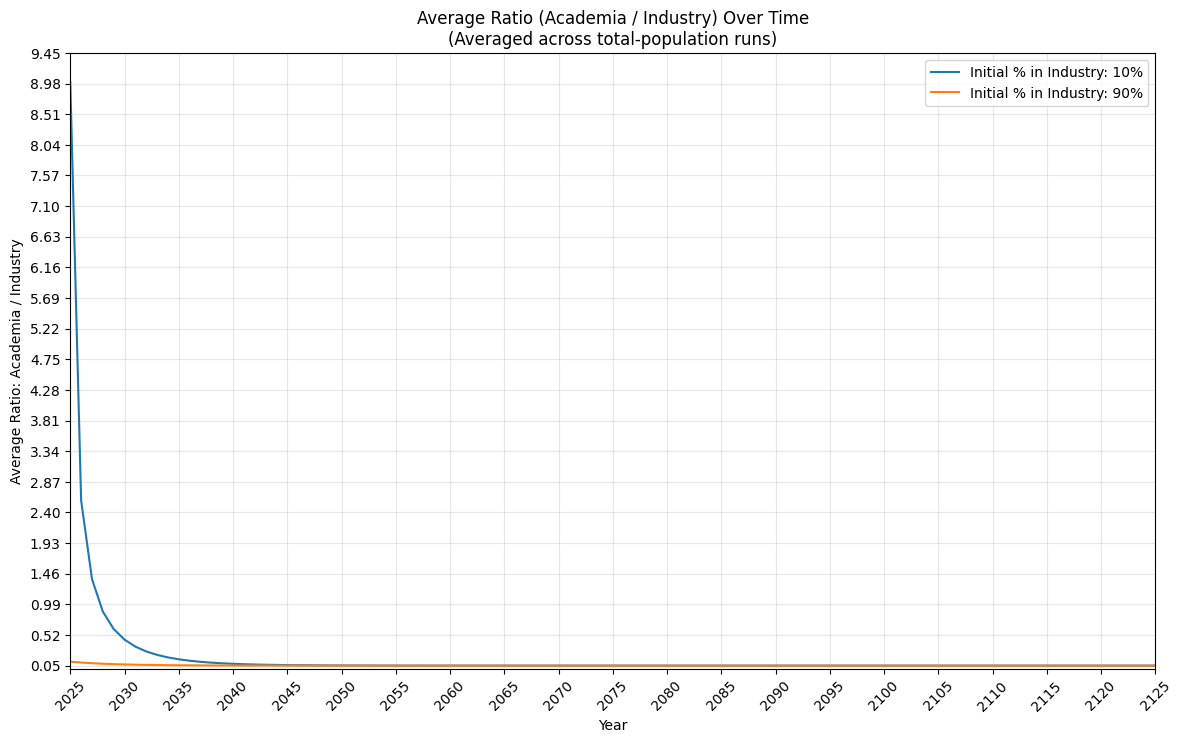

Results: Percentage 0.1 -> Minimum Ratio Academia/Industry by 2125: 0.05
Results: Percentage 0.9 -> Minimum Ratio Academia/Industry by 2125: 0.05


In [ ]:
ratios_dict = AverageRatiosByPercentage(responses=Responses, weighted=True)
min_ratios_dict = PlotAverageRatiosOverTime(avg_ratios=ratios_dict, initial_year=initialYear)

for item in min_ratios_dict:
    for percenta, min_ration in item.items():
        print(f"Results: Percentage {Colored(percenta, 'yellow')} -> Minimum Ratio Academia/Industry by 2125: {Colored(f'{min_ration:.2f}', 'green')}")


We can see that the ratio of people in industry vs academia decrease over time, and converges to a value around 0.05.

In [ ]:
import pandas as pd


def FindConvergenceIndex(vector: np.ndarray, tolerance: float = 0.01, window_size: int = 5) -> int:
    diffs = np.abs(np.diff(vector))
    
    for i in range(len(diffs) - window_size + 1):
        window = diffs[i:i + window_size]
        if np.all(window < tolerance):
            return i + window_size
    
    return -1

def CreateConvergenceDataFrame(
    ratios_dict: dict[float, dict[int, np.ndarray]], 
    initialYear: int, tolerance: float = 0.01, window_size: int = 5,
) -> pd.DataFrame:

    data_convergence = {
        'Initial_Percentage': [], 'Total_People': [],
        'Convergence_Year_Index': [], 'Convergence_Year': [], 'Converged': [], 'Convergence_Value': [],
    }

    for percentage, ratios_per_people in ratios_dict.items():

        for total_people, ratio in ratios_per_people.items():
            
            convergence_index = FindConvergenceIndex(vector=ratio, tolerance=tolerance, window_size=window_size)
            
            data_convergence['Initial_Percentage'].append(percentage)
            data_convergence['Total_People'].append(total_people)
            
            if convergence_index != -1:
                year = initialYear + convergence_index
                data_convergence['Convergence_Year_Index'].append(convergence_index)
                data_convergence['Convergence_Year'].append(year)
                data_convergence['Converged'].append(True)
                data_convergence['Convergence_Value'].append(ratio[convergence_index])
            else:
                data_convergence['Convergence_Year_Index'].append(np.nan)
                data_convergence['Convergence_Year'].append(np.nan)
                data_convergence['Converged'].append(False)
                data_convergence['Convergence_Value'].append(np.nan)

    df_convergence = pd.DataFrame(data_convergence)

    df_convergence['Convergence_Year'] = df_convergence['Convergence_Year'].astype('Int64')
    df_convergence['Convergence_Year_Index'] = df_convergence['Convergence_Year_Index'].astype('Int64')
    df_convergence = df_convergence.sort_values(by=['Initial_Percentage', 'Total_People'])
    
    return df_convergence



Let's us now see this convergence and how fast it happens:

In [55]:
all_ratios_dict = GetAllRatios(Responses)
df_convergence = CreateConvergenceDataFrame(all_ratios_dict, initialYear)

df_convergence


,Initial_Percentage,Total_People,Convergence_Year_Index,Convergence_Year,Converged,Convergence_Value
0,0.1,10000,18,2043,True,0.063675
1,0.1,20000,18,2043,True,0.063675
2,0.1,30000,18,2043,True,0.063675
3,0.1,40000,18,2043,True,0.063675
4,0.1,50000,18,2043,True,0.063675
5,0.1,60000,18,2043,True,0.063675
6,0.1,70000,18,2043,True,0.063675
7,0.1,80000,18,2043,True,0.063675
8,0.9,10000,7,2032,True,0.061209
9,0.9,20000,7,2032,True,0.061209


`(c)` Compute eigenvalues and eigenvectors of the transition matrix T and note that one of the eigenvalues is equal to 1. 
How is this (and the corresponding eigenvector) related to the evolution of the industry vs. academia research distribution that you have observed in the previous task? Explain.


In [63]:
import numpy as np


def GetEigenValuesAndEigenVectors(matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigens_count = eigenvalues.shape[0]

    all_eigens = []
    for i in range(eigens_count):
        all_eigens.append({
            'eigenvalue': eigenvalues[i],
            'eigenvector': eigenvectors[:, i],
        })
    
    return all_eigens


In [160]:
all_eigens = GetEigenValuesAndEigenVectors(transitionMatrix)

eigenvalue_1, eigenvector_1 = all_eigens[0]['eigenvalue'], all_eigens[0]['eigenvector']
eigenvalue_2, eigenvector_2 = all_eigens[1]['eigenvalue'], all_eigens[1]['eigenvector']


print(f"Eigenvalue 1: {Colored(f'{eigenvalue_1}', 'yellow')}, Eigenvector 1: {Colored(f'{eigenvector_1}', 'green')}")
print(f"Eigenvalue 2: {Colored(f'{eigenvalue_2}', 'yellow')}, Eigenvector 2: {Colored(f'{eigenvector_2}', 'green')}")


Eigenvalue 1: 1.0, Eigenvector 1: [0.99875234 0.04993762]
Eigenvalue 2: 0.79, Eigenvector 2: [-0.70710678  0.70710678]


***"In linear algebra, a Markov chain describes systems whose future states depend only on the current state. It's represented by a stochastic matrix, where each row sums to one. The state of the system at any time step is a probability vector that is updated by multiplying the current state vector by the transition matrix. This matrix multiplication allows for calculations of future probabilities and analysis of the system's long-term steady state. "***


This a very important property of Markov chains, as it indicates that the system will eventually reach a steady state, regardless of the initial distribution of states.


In [163]:
eigenvector_normalized = eigenvector_1 / sum(eigenvector_1)
half_life = np.log(0.5) / np.log(eigenvalue_2) if eigenvalue_2 != 0 else float('inf')

print(f"EingenValues: {Colored(f'{[float(eigenvalue_1), float(eigenvalue_2)]}', 'yellow')}")
print(f"Steady State Shares: {Colored(f'{eigenvector_normalized}', 'blue')} (sum = {Colored(f'{sum(eigenvector_normalized)}', 'red')})")
print(f"Half-Life of Convergence: {Colored(f'{half_life:.2f} years', 'magenta')}")


EingenValues: [1.0, 0.79]
Steady State Shares: [0.95238095 0.04761905] (sum = 1.0)
Half-Life of Convergence: 2.94 years



* **Eigenvalue 1 $\Rightarrow$ steady state.** Because $(\mathbf{x}_{t+1}=T \mathbf{x}_t)$, any initial composition $(\mathbf{x}_0)$ converges to a multiple of the eigenvector for $(\lambda=1)$. After normalizing, that multiple is exactly the **long-run share**: $\approx 95.238\%$ in industry and $\approx 4.762\%$ in academia.


* **Second eigenvalue ($0.79$) $\Rightarrow$ speed of convergence.** Decompose $(\mathbf{x}_0)$ in the eigenbasis; the component along the second eigenvector gets multiplied by $(0.79^t)$. Since $(|0.79|<1)$, it decays quickly. The "half-life" of deviations is
$$
\frac{\ln 0.5}{\ln 0.79}\approx 2.94\ \text{years},
$$
so we should see the curve settle near the steady state in just a handful of years, and be essentially there long before year 100, and that is indeed what we observe in the plots.